<a href="https://colab.research.google.com/github/alirezaght/bitcoin-price-prediction/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download historical data

First we need to download the latest csv of historical data of bitcoin prices.

In [1]:
import pandas as pd
import requests
import json

def fetch_daily_data(symbol):
    pair_split = symbol.split('/')  # symbol must be in format XXX/XXX ie. BTC/EUR
    symbol = pair_split[0] + '-' + pair_split[1]
    url = f'https://api.pro.coinbase.com/products/{symbol}/candles?granularity=86400'
    response = requests.get(url)
    if response.status_code == 200:  # check to make sure the response from server is good
        data = pd.DataFrame(json.loads(response.text), columns=['unix', 'low', 'high', 'open', 'close', 'volume'])
        data['date'] = pd.to_datetime(data['unix'], unit='s')  # convert to a readable date
        data['vol_fiat'] = data['volume'] * data['close']      # multiply the BTC volume by closing price to approximate fiat volume

        # if we failed to get any data, print an error...otherwise write the file
        if data is None:
            print("Did not return any data from Coinbase for this symbol")
        else:
            print("Data downloaded.")
            return data

    else:
        print("Did not receieve OK response from Coinbase API")

data = fetch_daily_data("BTC/USD")
print(f"{len(data)} Rows downloaded")

Data downloaded.
300 Rows downloaded


# Create trainsets and testsets

We want to have a function to pick batch number from the dataset so the input will be like `close price in day n, volume in day n, close price in day n+1, volume in day n+1, ...`


In [2]:
from numpy import ndarray
import numpy as np
import random



def create_batch(batch_number: int, days_in_batch: int, predict_day: int, data_set: ndarray):
  train_x = np.zeros((batch_number, 2 * days_in_batch))
  train_y = np.zeros(batch_number)
  test_x = np.zeros((batch_number, 2 * days_in_batch))
  test_y = np.zeros(batch_number)
  d = np.zeros((batch_number, 2 * days_in_batch + predict_day))
  for i in range(batch_number):
    rand = random.randint(days_in_batch + predict_day, len(data_set) - 1)
    count = 0
    
    while count < days_in_batch:       
      d[i][count * 2] = data_set["close"][rand]
      d[i][(count * 2) + 1] = data_set["volume"][rand]
      count += 1
      rand -= 1
    for j in range(predict_day):
      d[i][-predict_day + j] = data_set["close"][rand - j]
    
  
  np.random.shuffle(d)

  train_size = int(0.8 * batch_number)
  
  train_x = d[0: train_size, 0:-predict_day]
  train_y = d[0: train_size, -predict_day:]
  test_x = d[train_size:, 0:-predict_day]
  test_y = d[train_size:, -predict_day:]

  train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1],1))
  test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1],1))

  return train_x, train_y, test_x, test_y

predict_day = 7
batch_number = 1000
days_in_batch = 30

train_x, train_y, test_x, test_y = create_batch(batch_number, days_in_batch, predict_day, data)

# Create Model

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import SGD

class TrainingStop(keras.callbacks.Callback):
    def __init__(self, threshold):
        super(TrainingStop, self).__init__()
        self._threshold = threshold

    def on_epoch_end(self, batch, logs={}):        
        train_loss = logs.get('loss')
        self.model.stop_training = train_loss <= self._threshold

model = keras.Sequential()

# Add a LSTM layer with 128 internal units.
model.add(layers.GRU(128, activation="relu", return_sequences=True))
model.add(layers.GRU(128, activation="relu"))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(predict_day, activation="relu"))

model.compile(optimizer="rmsprop", loss="mae")
model.fit(train_x, train_y, epochs=10000, callbacks=[TrainingStop(500)])



Epoch 1/10000
25/25 [==============================] - 4s 87ms/step - loss: 36006.9375
Epoch 2/10000
25/25 [==============================] - 2s 85ms/step - loss: 16183.5127
Epoch 3/10000
25/25 [==============================] - 2s 84ms/step - loss: 12263.2773
Epoch 4/10000
25/25 [==============================] - 2s 83ms/step - loss: 11650.2324
Epoch 5/10000
25/25 [==============================] - 2s 84ms/step - loss: 11603.6250
Epoch 6/10000
25/25 [==============================] - 2s 84ms/step - loss: 11057.3916
Epoch 7/10000
25/25 [==============================] - 2s 85ms/step - loss: 11014.8320
Epoch 8/10000
25/25 [==============================] - 2s 84ms/step - loss: 11213.4824
Epoch 9/10000
25/25 [==============================] - 2s 85ms/step - loss: 10801.3203
Epoch 10/10000
25/25 [==============================] - 2s 84ms/step - loss: 10802.9805
Epoch 11/10000
25/25 [==============================] - 2s 86ms/step - loss: 10946.2197
Epoch 12/10000
25/25 [===================

# Predict

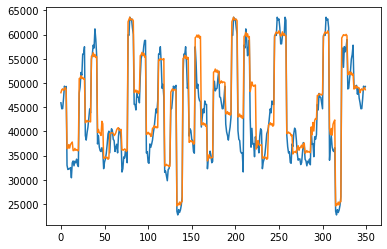

In [4]:
import matplotlib.pyplot as plt

def plot(sliced_data: ndarray):  
  p_data = np.reshape(sliced_data, (predict_day * len(sliced_data),))
  plt.plot(p_data)

plot(test_y[0:50])
predicted = model.predict(test_x)
plot(predicted[0:50])


